# Agtuary ML Challenge - 2. EDA

This notebook contains the exploratory data analysis (EDA) performed as part of the [Agtuary ML Challenge](https://github.com/agtuary/machine-learning-challenge).

This is a one-shot in-season crop classification challenge. The dataset contains values corresponding to wavelengths of light (known as 'bands') for pixels captured by the Sentinel-2 satellite. The task is to use these values to classify each pixel as belonging to a type of crop. In this notebook, the data is explored to glean insights about the properties of each crop type and inform strategies for implementing a machine learning classifier.

My approach in this notebook follows a few standard steps, including checking for missing data and examining the class balance in the training set. I also wanted to visualise the spatial distribution of the classes in the training data to see if I could reveal geographical information and features. The summary statistics for each band are reflected in the prescribed visualisation, which indicates that while identifying Cotton should be simple for even an unskilled model, accurately distinguishing between Sorghum and the majority class, Other, will prove difficult from the provided features alone. A pairwise plot coloured by class revealed little in the way of distinguishing features. From my research I identified two potentially useful satellite indices that didn't require Band 5 (705nm), the Global Environmental Monitoring Index (GEMI) and the Normalized Difference Moisture Index (NDMI). However these indices failed to separate the classes further. Finally, I generated a correlation matrix to investigate the relationships between each feature and the target variable, which could be used to select features to reduce multicollinearity, which can be an issue for certain linear models.

Helpful links:
* https://gisgeography.com/sentinel-2-bands-combinations/
* https://spj.sciencemag.org/journals/plantphenomics/2021/9874650/ - use of GEMI in Sorghum head detection


NB: generating some charts in this notebook requires the [seaborn](http://seaborn.pydata.org/) package

In [1]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, cohen_kappa_score, make_scorer
from sklearn.neural_network import MLPClassifier

import os
import glob
import pickle

pd.options.mode.chained_assignment = None

In [2]:
#!pip install seaborn
import seaborn as sns

In [3]:
def load_image(path):
    return np.array(PIL.Image.open(path))[:, :]

In [4]:
bands = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']

In [5]:
# get the current working directory
path = os.getcwd()
print(path)

/home/lachy/dml/agtuary-machine-learning-challenge-master


In [6]:
# get location of data subfolder
subfolder = "data_raw"
data_dir = os.path.join(path, subfolder)
print(data_dir)

/home/lachy/dml/agtuary-machine-learning-challenge-master/data_raw


In [7]:
# load training dataset
pixels = pd.read_csv(data_dir + "/pixels.csv")

## Data Analysis

In [8]:
# get dimensions of data
no_rows = pixels.shape[0]
no_cols = pixels.shape[1]
print(f"Data contains {no_rows} rows and {no_cols} columns.")

Data contains 299894 rows and 15 columns.


In [9]:
# check for NaN values
pixels.isna().sum()

B01           0
B02           0
B03           0
B04           0
B05           0
B06           0
B07           0
B08           0
B8A           0
B09           0
B11           0
B12           0
label_id      0
cloud_prob    0
label         0
dtype: int64

In [10]:
# get class balances
round(pixels.label.value_counts() / len(pixels) * 100, 2)
#dataset is 92% 'Other', 4.5% 'Sorghum' and 3.7% 'Cotton'

Other      91.82
Sorghum     4.49
Cotton      3.70
Name: label, dtype: float64

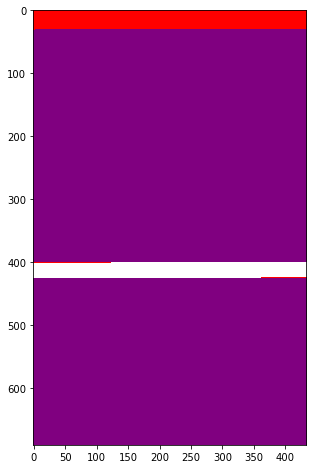

In [11]:
# plot distribution of classes in data
label_ids = [0, 1, 2]
colours = ['purple', 'red', 'white']

cmap_ag = mcolors.ListedColormap(colours)
cmap_ag.set_bad(color='lightgrey')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
ax.grid(False)
ax.imshow(np.reshape(pixels.label_id.ravel(), (691, 434)), cmap=cmap_ag, aspect='equal')

#dataset appears to have been pre-sorted (spatial information removed)

In [12]:
# get first row of each class
pixels.groupby(by=['label']).first().sort_values('label_id')

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12,label_id,cloud_prob
label,,,,,,,,,,,,,,
Other,0.0964,0.1204,0.1290,0.1494,0.1625,0.1668,0.1728,0.1922,0.1898,0.2497,0.2600,0.2384,0,0.0
Sorghum,0.0724,0.0984,0.1148,0.1424,0.1523,0.1629,0.1765,0.1998,0.1959,0.2011,0.3177,0.2703,1,0.0
Cotton,0.0332,0.0183,0.0357,0.0221,0.0604,0.3303,0.4579,0.4544,0.4742,0.3378,0.1583,0.0700,2,0.0


In [13]:
pixels[bands].describe().round(2)

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B11,B12
count,299894.00,299894.00,299894.00,299894.00,299894.00,299894.00,299894.00,299894.00,299894.00,299894.00,299894.00,299894.00
mean,0.06,0.08,0.10,0.11,0.14,0.19,0.22,0.23,0.24,0.25,0.25,0.20
std,0.03,0.03,0.03,0.05,0.04,0.06,0.08,0.09,0.09,0.10,0.08,0.09
min,0.01,0.01,0.01,0.01,0.01,0.04,0.05,0.04,0.05,0.04,0.02,0.02
25%,0.05,0.06,0.08,0.08,0.12,0.16,0.17,0.18,0.19,0.19,0.20,0.13
50%,0.06,0.07,0.10,0.10,0.14,0.19,0.20,0.21,0.22,0.23,0.25,0.21
75%,0.08,0.10,0.12,0.15,0.17,0.23,0.26,0.27,0.28,0.29,0.32,0.28
max,0.52,0.46,0.40,0.57,0.59,0.57,0.60,0.62,0.63,1.00,0.56,0.53


In [14]:
# set variable groups
bands = ['B01', 'B02', 'B03', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']
indices = ['ndmi', 'gemi']
cloud_prob = ['cloud_prob']
dummies = ['s_dummy', 'c_dummy', 'o_dummy']
label = ['label_id']

In [15]:
label_mapper = {0: 'Other', 1:'Sorghum', 2:'Cotton'}
label_mapper.values()

dict_values(['Other', 'Sorghum', 'Cotton'])

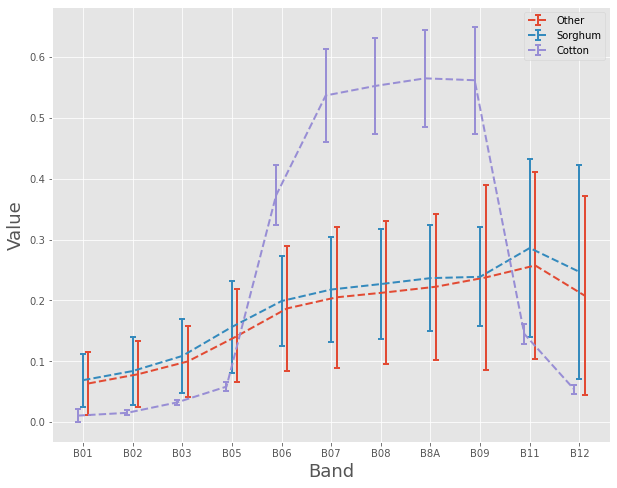

In [16]:
#plot the mean band values of each crop type and +- 2 standard deviations
bands_mu = pixels[bands + label].groupby(by=label).mean()
bands_two_sig = pixels[bands + label].groupby(by=label).std() * 2

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.set_xlabel('Band', fontsize=18)
ax.set_ylabel('Value', fontsize=18)

xaxis = np.arange(1, len(bands_mu.columns)+1)

lineStyle={"linestyle":"--", "linewidth":2, "markeredgewidth":2, "elinewidth":2, "capsize":3}

offset = xaxis.max()/100

line_a=ax.errorbar(xaxis+offset, bands_mu.loc[0], yerr=bands_two_sig.loc[0], label=label_mapper[0], **lineStyle)
line_b=ax.errorbar(xaxis, bands_mu.loc[1], yerr=bands_two_sig.loc[1], label=label_mapper[1], **lineStyle)
line_c=ax.errorbar(xaxis-offset, bands_mu.loc[2], yerr=bands_two_sig.loc[2], label=label_mapper[2], **lineStyle)

plt.xticks(ticks=xaxis, labels=bands_mu.columns.tolist())  

plt.legend(handles=[line_a, line_b, line_c])

plt.show()

# Cotton class is fairly unique, decent classifier should only have trouble classifying Sorghum vs Other

In [17]:
# remove band B04 and any pixels with cloud prob > 2
df = pixels[pixels['cloud_prob'] <= 2].drop(columns=['B04'])

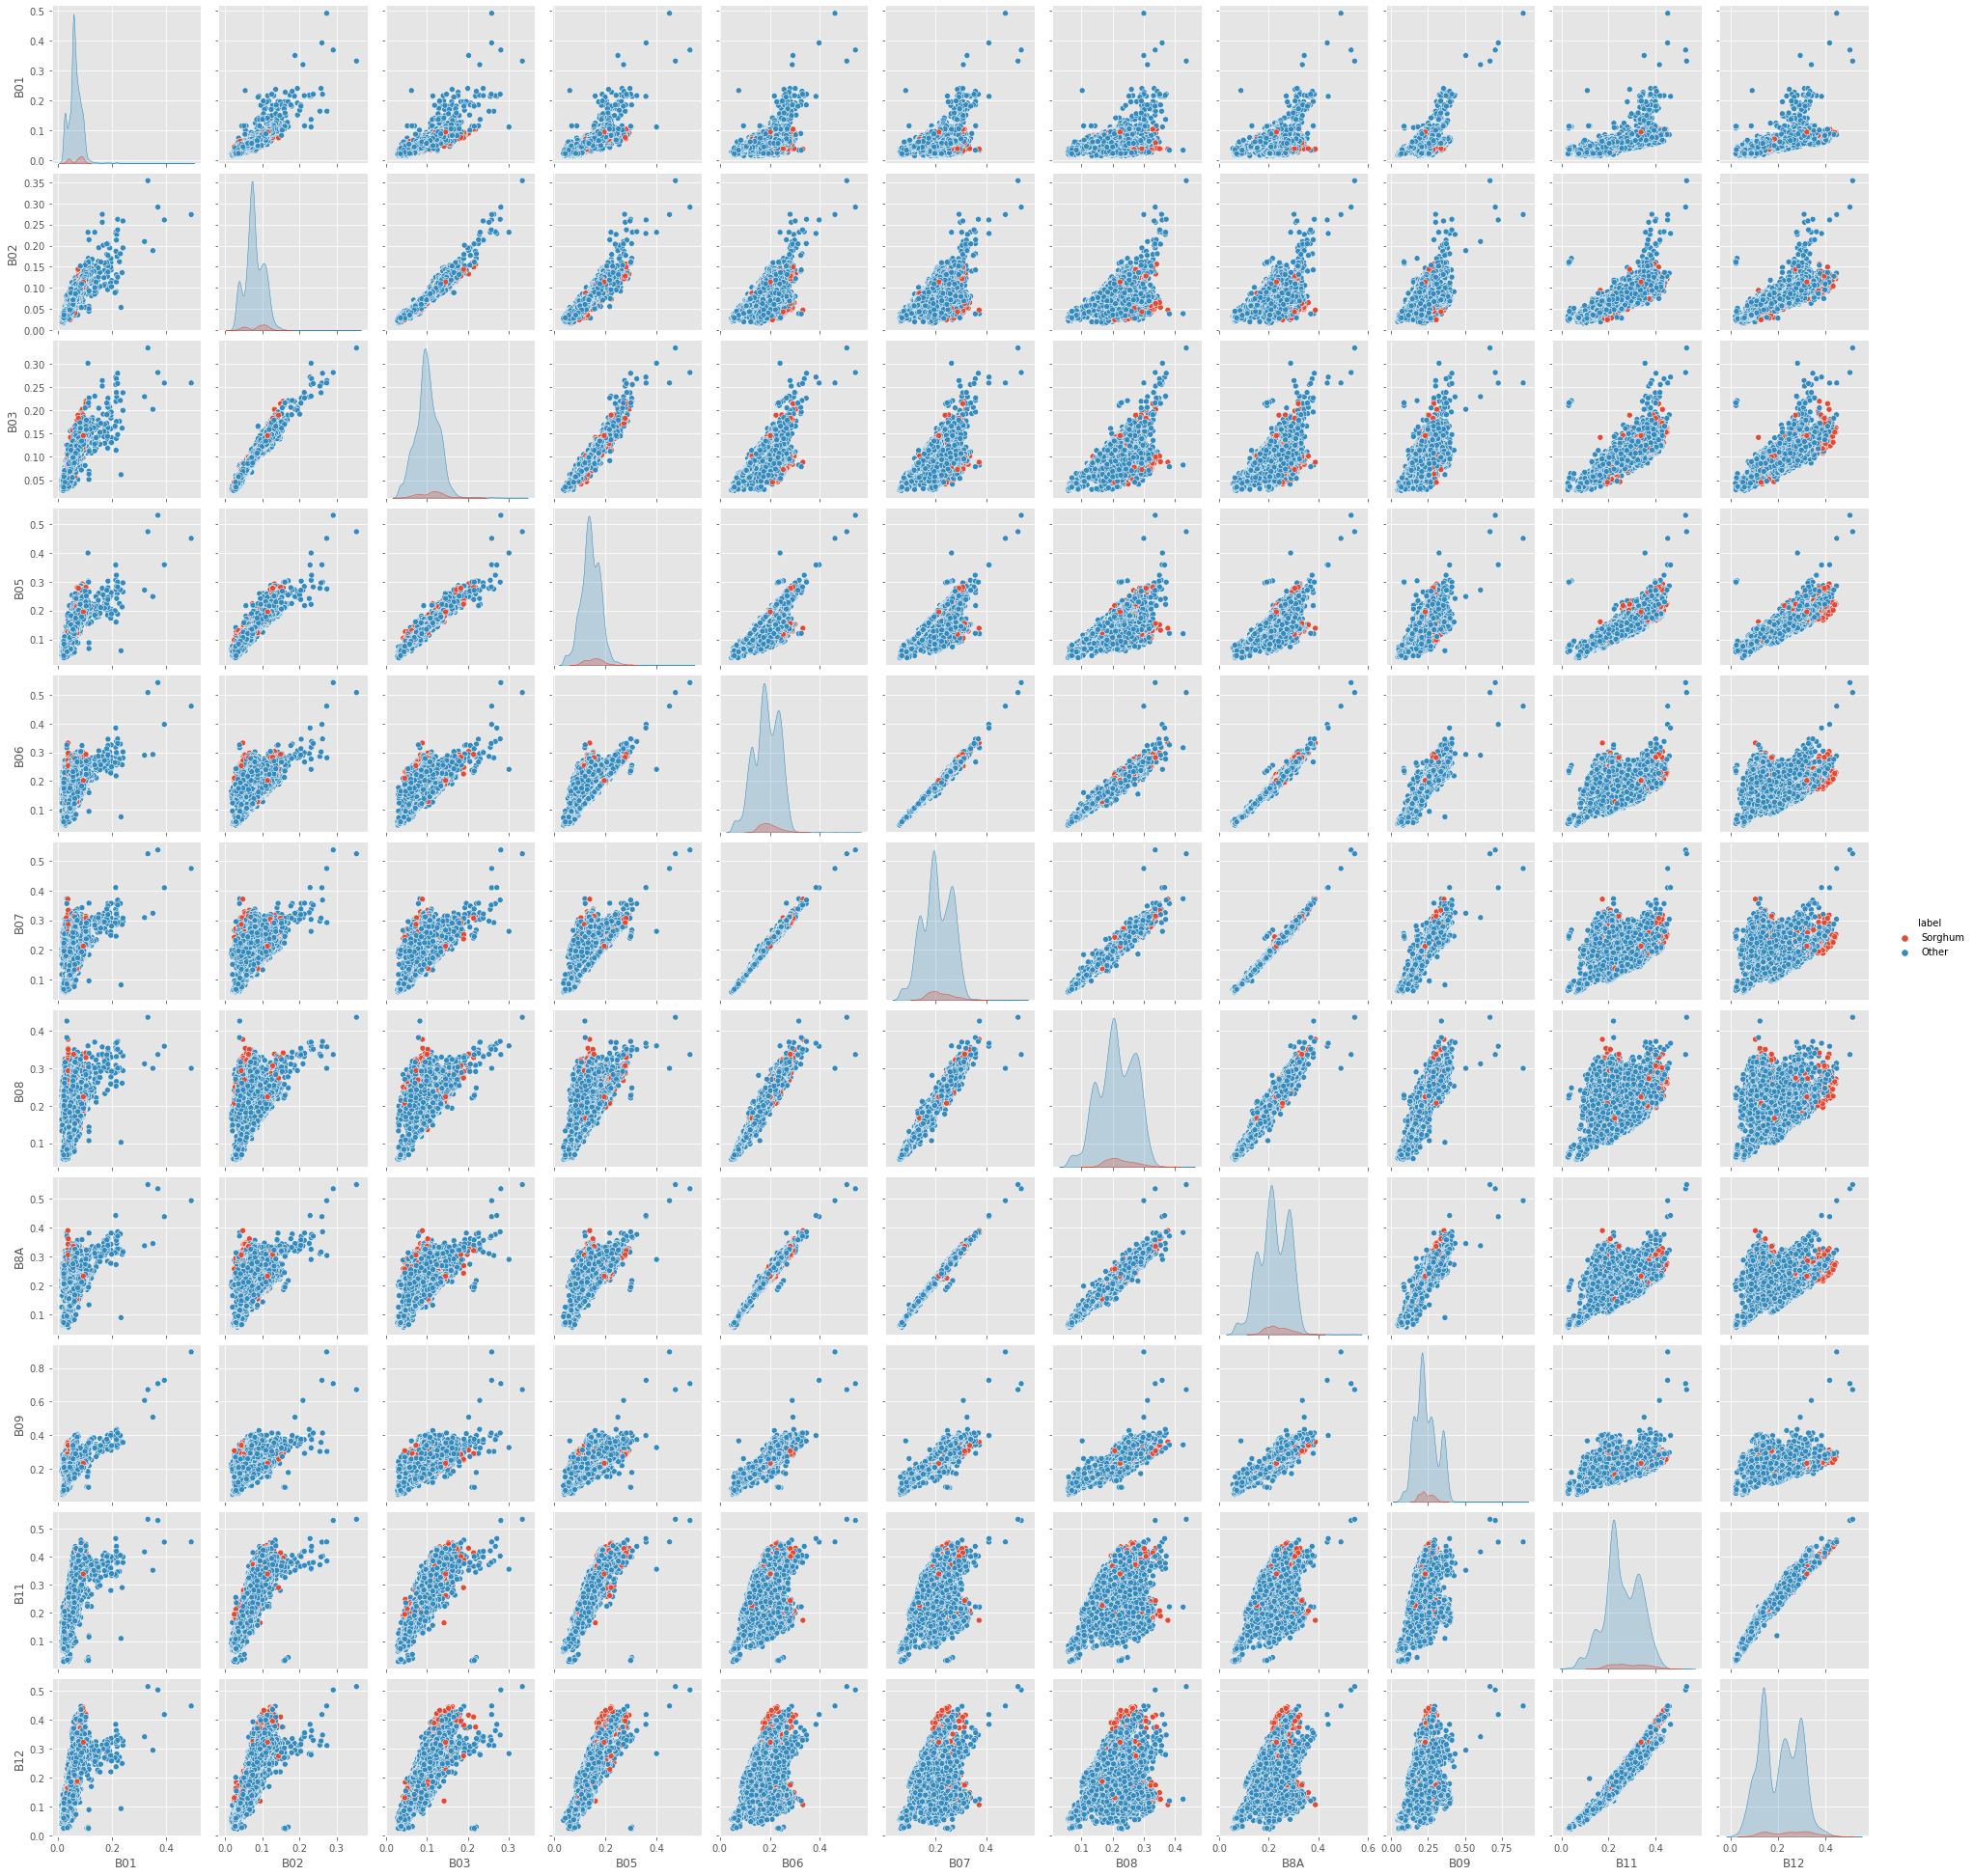

In [18]:
# plot band distributions of Sorghum vs Other
pairplot_data = df[df['label'] != 'Cotton'].drop(columns=['cloud_prob', 'label_id']).sample(10000)
sns.pairplot(pairplot_data, hue='label', hue_order=['Sorghum', 'Other'], corner=False)

In [19]:
#NDMI index
def calc_ndmi(df):
    df['ndmi'] = (df.B08 - df.B11) / (df.B08 + df.B11)
    return df

In [20]:
#GEMI index
def calc_gemi(df):
    gemi_w = (2*(df.B09**2 - df.B05**2) + 1.5*df.B09 + 0.5*df.B05) / (df.B09 + df.B05 + 0.5)
    df['gemi'] = (gemi_w * (1 - 0.25*gemi_w) - (df.B05-0.125)/(1-df.B05))
    return df

In [21]:
def calc_indices(df):
    df = calc_ndmi(df)
    df = calc_gemi(df)
    return df

In [22]:
df = calc_indices(df)

In [25]:
df[indices].describe()

,ndmi,gemi
count,297351.000000,297351.000000
mean,-0.065447,0.473493
std,0.225852,0.143071
min,-0.477977,-0.275992
25%,-0.253491,0.363929
50%,-0.143096,0.412812
75%,0.113287,0.559376
max,0.804859,0.997361


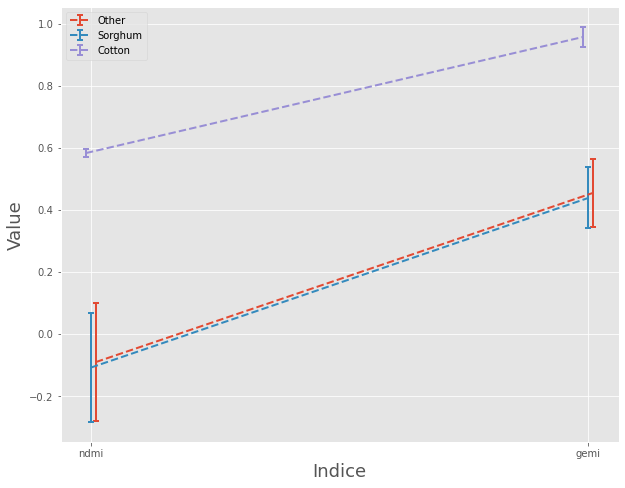

In [23]:
#plot indice mean values with 2 standard deviations
indice_mu = df[indices + label].groupby(by=label).mean()
indice_two_sig = df[indices + label].groupby(by=label).std()

plt.style.use('ggplot')

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.set_xlabel('Indice', fontsize=18)
ax.set_ylabel('Value', fontsize=18)

xaxis = np.arange(1, len(indice_mu.columns)+1)

lineStyle={"linestyle":"--", "linewidth":2, "markeredgewidth":2, "elinewidth":2, "capsize":3}

offset = xaxis.max()/200

line_a=ax.errorbar(xaxis+offset, indice_mu.loc[0], yerr=indice_two_sig.loc[0], label=label_mapper[0], **lineStyle)
line_b=ax.errorbar(xaxis, indice_mu.loc[1], yerr=indice_two_sig.loc[1], label=label_mapper[1], **lineStyle)
line_c=ax.errorbar(xaxis-offset, indice_mu.loc[2], yerr=indice_two_sig.loc[2], label=label_mapper[2], **lineStyle)

plt.xticks(ticks=xaxis, labels=indice_mu.columns.tolist())  

plt.legend(handles=[line_a, line_b, line_c])

plt.show()

In [24]:
#encode crop type labels to numeric value
df['s_dummy'] = np.where(df.label == 'Sorghum', 1, 0)
df['c_dummy'] = np.where(df.label == 'Cotton', 1, 0)
df['o_dummy'] = np.where(df.label == 'Other', 1, 0)

In [26]:
corr = df[bands + indices + dummies].corr()

corr.style.background_gradient(cmap='viridis').format('{:.2f}')

,B01,B02,B03,B05,B06,B07,B08,B8A,B09,B11,B12,ndmi,gemi,s_dummy,c_dummy,o_dummy
B01,1.00,0.92,0.89,0.86,-0.00,-0.14,-0.15,-0.13,-0.04,0.74,0.74,-0.52,-0.41,0.06,-0.38,0.21
B02,0.92,1.00,0.97,0.93,-0.05,-0.20,-0.19,-0.19,-0.14,0.84,0.85,-0.61,-0.52,0.05,-0.41,0.24
B03,0.89,0.97,1.00,0.97,0.07,-0.10,-0.09,-0.09,-0.05,0.84,0.83,-0.52,-0.44,0.08,-0.41,0.22
B05,0.86,0.93,0.97,1.00,0.13,-0.05,-0.04,-0.03,-0.01,0.88,0.85,-0.51,-0.41,0.09,-0.39,0.20
B06,-0.00,-0.05,0.07,0.13,1.00,0.97,0.96,0.97,0.95,-0.04,-0.22,0.71,0.81,0.02,0.58,-0.41
B07,-0.14,-0.20,-0.10,-0.05,0.97,1.00,0.99,1.00,0.96,-0.15,-0.32,0.76,0.86,0.00,0.74,-0.51
B08,-0.15,-0.19,-0.09,-0.04,0.96,0.99,1.00,0.99,0.95,-0.13,-0.30,0.76,0.86,0.00,0.75,-0.52
B8A,-0.13,-0.19,-0.09,-0.03,0.97,1.00,0.99,1.00,0.95,-0.12,-0.29,0.74,0.86,0.00,0.74,-0.52
B09,-0.04,-0.14,-0.05,-0.01,0.95,0.96,0.95,0.95,1.00,-0.14,-0.32,0.74,0.90,-0.02,0.65,-0.43
B11,0.74,0.84,0.84,0.88,-0.04,-0.15,-0.13,-0.12,-0.14,1.00,0.96,-0.70,-0.50,0.09,-0.28,0.13


In [27]:
#high collinearity between B02 & B03, B03 & B05, B06 & B07/8/8A, B11 & B12. Suggests multicollinearity (issue for linear models)
#7,8 and 8A have no correlation with Sorghum, so we will drop them
df = df.drop(columns=['B07', 'B08', 'B8A'])